# Imports

In [ ]:
from utils import preprocess, view_pred
from lstm import LSTM_extended
from lstm_hidden import LSTM_hidden_extended
from google.colab import drive
import ast
import joblib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Carga de los datos

In [ ]:
path_to_file = '/content/drive/MyDrive/TFM/Data/df.csv'

df = pd.read_csv(path_to_file)

df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df['supply'] = df['supply_60'].apply(lambda x: ast.literal_eval(x))
df['price'] = df['price_60'].apply(lambda x: ast.literal_eval(x))
df['weekday'] = df['date'].apply(lambda x: x.weekday())
df['month'] = df['date'].apply(lambda x: x.month)

In [ ]:
hour = 18
num_points = 60
hours_before = 24
valid = True

In [ ]:
out = preprocess(df, hour, hours_before, valid)
X_train, Y_train, X_valid, Y_valid, X_test, Y_test, Y_prev = out[0], out[1], out[2], out[3], out[4], out[5], out[6]

# Ejemplo de entrenamiento

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [75, 100, 125],
    'max_depth': [8, 10, None],
    'max_features': [None, 'sqrt']
}

my_RF = GridSearchCV(param_grid=param_grid, estimator=RFR(), scoring='neg_mean_squared_error')
my_RF.fit(X_train, Y_train)
print(my_RF.best_params_)

joblib.dump(my_RF, 'my_RF_' + str(hour) + '.joblib')

## LSTM

In [ ]:
input_size = num_points*hours_before + 3 + 4
hidden_size = 2048
hidden_1 = 1024
hidden_2 = 1024
hidden_3 = 512
hidden_4 = 256
n_labels = num_points
p = 0.2
patience = 15
epochs = 100
valid = True

my_LSTM = LSTM_extended(input_size, hidden_size, hidden_1, hidden_2, hidden_3, hidden_4, n_labels, p, patience, valid=valid, epochs=epochs)

my_LSTM.trainloop(X_train, Y_train, X_valid, Y_valid)

## LSTM hidden

In [ ]:
input_size = num_points*hours_before + 3 + 4
hidden_size = 2048 // 2
hidden_1 = 1024
hidden_2 = 1024
hidden_3 = 512
hidden_4 = 256
n_labels = num_points
p = 0.2
patience = 15
epochs = 100
valid = True

my_LSTM = LSTM_extended(input_size, hidden_size, hidden_1, hidden_2, hidden_3, hidden_4, n_labels, p, patience, valid=valid, epochs=epochs)

my_LSTM.trainloop(X_train, Y_train, X_valid, Y_valid)

# Ejemplo de predicciones

## Carga Random Forest

In [ ]:
path = '/content/drive/MyDrive/TFM/Models/Random_Forest/my_RF_' + str(hour) + '.joblib'
my_RF = joblib.load(path)

## Carga LSTM

In [ ]:
path = '/content/drive/MyDrive/TFM/Models/LSTM/LSTM_' + str(hour) + '.pt'

input_size = num_points*hours_before + 3 + 4
hidden_size = 2048
hidden_1 = 1024
hidden_2 = 1024
hidden_3 = 512
hidden_4 = 256
n_labels = num_points
p = 0.2
patience = 15

my_LSTM = LSTM_extended(input_size, hidden_size, hidden_1, hidden_2, hidden_3, hidden_4, n_labels, p, patience)

my_LSTM.load_state_dict(torch.load(path))

<All keys matched successfully>

## Carga LSTM hidden

In [ ]:
path = '/content/drive/MyDrive/TFM/Models/LSTM_hidden/LSTM_hidden_' + str(12) + '.pt'

input_size = num_points*hours_before + 3 + 4
hidden_size = 2048 // 2
hidden_1 = 1024
hidden_2 = 1024
hidden_3 = 512
hidden_4 = 256
n_labels = num_points
p = 0.2
patience = 15

my_LSTM_hidden = LSTM_hidden_extended(input_size, hidden_size, hidden_1, hidden_2, hidden_3, hidden_4, n_labels, p, patience)

my_LSTM_hidden.load_state_dict(torch.load(path))

<All keys matched successfully>

## Predicciones

In [ ]:
min_x = 16916.4
max_x = 122681.6

In [ ]:
Y_pred_RF = my_RF.predict(X_test)*(max_x-min_x) + min_x
Y_pred_LSTM = my_LSTM.predict(X_test)
Y_pred_LSTM_hidden = my_LSTM_hidden.predict(X_test)
Y_test = np.array(Y_test)*(max_x-min_x) + min_x

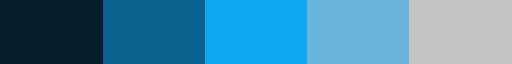

In [ ]:
# Mapa degradado de colores

colors = [(5/255, 28/255, 44/255), (14/255, 169/255, 240/255), (195/255, 195/255, 195/255)]
cmap = LinearSegmentedColormap.from_list('Degradado', colors, N=5)
cmap

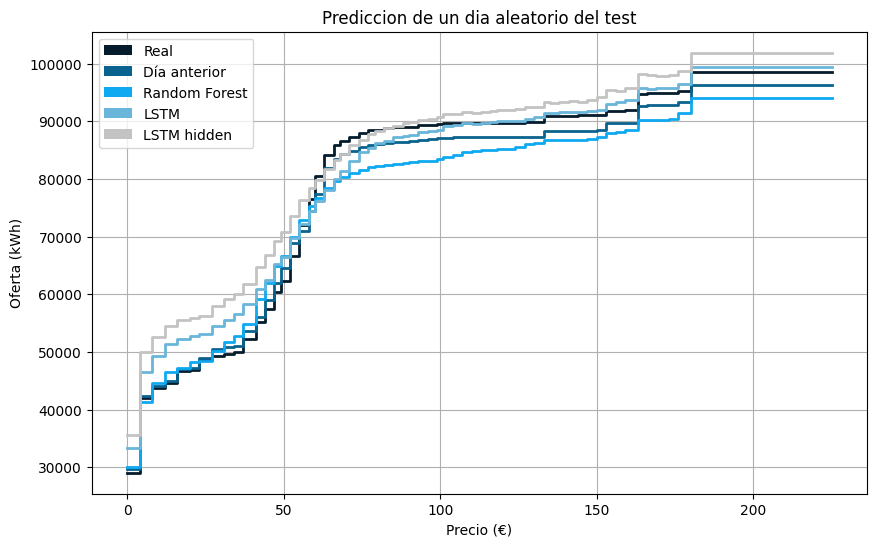

In [ ]:
view_pred(
    df['price'].loc[0] + [225],
    Y_test,
    Y_prev,
    Y_pred_RF,
    Y_pred_LSTM,
    Y_pred_LSTM_hidden,
    cmap
)